---
### XÂY DỰNG HỆ THỐNG GỢI Ý MOVIES
Dự án này sẽ xây dựng một hệ thống đề xuất dựa trên tập dữ liệu Movies.

<img src='Pic/pic1.png' width='500px'>

Dựa vào dữ liệu của trên 12 182 bộ films, xây dựng hệ thống đề xuất đưa ra danh sách 15 bộ film liên quan. Có hai loại Recommender system được xây dựng trong project này:


*   Simple Recommender
*   Content-Based Recommender

Các file dữ liệu sử dụng bao gồm:

**Data_Movies.csv:** File này chứa thông tin tổng hợp của ~ 12 000 bộ film, mỗi bộ film có 24 thuộc tính khác nhau, một số thuộc tính chính bao gồm:

1. adult: Bộ film dành cho người lớn hay không. Dữ liệu boolean (True - Flase)
2. original_language: Ngôn ngữ ban đầu; dữ liệu categorical
3. genres: Thể loại film
4. original_title: Tiêu đề của film, dữ liệu text
5. overview: Tóm tắt nội dung của film; Dữ liệu text
6. release_date: Ngày phát hành films
7. vote_average: Điểm đánh giá trung bình cho bộ phim [0: dở tệ - 10: Xuất sắc]
8. vote_count: Số lượt xem đánh giá bộ phim

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast

#Đọc tập dữ liệu thông tin của các film
file_path = 'Data/Data_Movies.csv'
data_movies = pd.read_csv(file_path)

#Hiển thị thông tin tập dữ liệu
data_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12182 entries, 0 to 12181
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  12182 non-null  bool   
 1   belongs_to_collection  2409 non-null   object 
 2   budget                 12182 non-null  int64  
 3   genres                 12182 non-null  object 
 4   homepage               3330 non-null   object 
 5   id                     12182 non-null  int64  
 6   imdb_id                12180 non-null  object 
 7   original_language      12182 non-null  object 
 8   original_title         12182 non-null  object 
 9   overview               12119 non-null  object 
 10  popularity             12182 non-null  float64
 11  poster_path            12182 non-null  object 
 12  production_companies   12182 non-null  object 
 13  production_countries   12182 non-null  object 
 14  release_date           12180 non-null  object 
 15  re

In [3]:
# Loại bỏ các cột không cần thiết
columns_to_drop = ['homepage', 'belongs_to_collection', 'tagline', 'poster_path']
data_cleaned = data_movies.drop(columns=columns_to_drop)


In [4]:
data_cleaned.columns

Index(['adult', 'budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'title', 'video', 'vote_average',
       'vote_count'],
      dtype='object')

In [5]:
# Điền giá trị thiếu cho 'runtime' bằng giá trị trung bình
data_cleaned['runtime'].fillna(data_cleaned['runtime'].mean(), inplace=True)

In [6]:
# Loại bỏ các hàng thiếu dữ liệu ở các cột quan trọng
data_cleaned.dropna(subset=['release_date', 'overview'], inplace=True)

In [7]:
# Chuyển đổi 'release_date' sang định dạng datetime
data_cleaned['release_date'] = pd.to_datetime(data_cleaned['release_date'], errors='coerce')

In [8]:
# Loại bỏ các hàng không thể chuyển đổi được trong 'release_date'
data_cleaned.dropna(subset=['release_date'], inplace=True)

In [9]:
# Loại bỏ dữ liệu trùng lặp (nếu có)
data_cleaned = data_cleaned.drop_duplicates()

In [10]:
# Thống kê tổng quan sau xử lý
data_cleaned_info = {
    "remaining_rows": data_cleaned.shape[0],
    "remaining_columns": data_cleaned.shape[1],
    "missing_values": data_cleaned.isnull().sum()
}

data_cleaned_info

{'remaining_rows': 12113,
 'remaining_columns': 20,
 'missing_values': adult                   0
 budget                  0
 genres                  0
 id                      0
 imdb_id                 2
 original_language       0
 original_title          0
 overview                0
 popularity              0
 production_companies    0
 production_countries    0
 release_date            0
 revenue                 0
 runtime                 0
 spoken_languages        0
 status                  1
 title                   0
 video                   0
 vote_average            0
 vote_count              0
 dtype: int64}

In [11]:
# Xử lý cột 'imdb_id': Thay thế giá trị thiếu bằng 'unknown'
data_cleaned['imdb_id'].fillna('unknown', inplace=True)

# Xử lý cột 'status': Điền giá trị phổ biến nhất
most_common_status = data_cleaned['status'].mode()[0]
data_cleaned['status'].fillna(most_common_status, inplace=True)

# Kiểm tra lại xem còn giá trị thiếu không
missing_values_after = data_cleaned.isnull().sum()
missing_values_after


adult                   0
budget                  0
genres                  0
id                      0
imdb_id                 0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
title                   0
video                   0
vote_average            0
vote_count              0
dtype: int64

In [12]:
# Kiểm tra các cột quan trọng
important_columns = {
    "budget_stats": data_cleaned['budget'].describe(),
    "revenue_stats": data_cleaned['revenue'].describe(),
    "vote_average_stats": data_cleaned['vote_average'].describe(),
    "vote_count_stats": data_cleaned['vote_count'].describe(),
    "genres_sample": data_cleaned['genres'].head(),  # Một vài giá trị trong 'genres'
    "production_companies_sample": data_cleaned['production_companies'].head()
}

important_columns


{'budget_stats': count    1.211300e+04
 mean     1.481464e+07
 std      3.110243e+07
 min      0.000000e+00
 25%      0.000000e+00
 50%      7.000000e+00
 75%      1.500000e+07
 max      3.800000e+08
 Name: budget, dtype: float64,
 'revenue_stats': count    1.211300e+04
 mean     4.131253e+07
 std      1.194474e+08
 min      0.000000e+00
 25%      0.000000e+00
 50%      0.000000e+00
 75%      2.633048e+07
 max      2.787965e+09
 Name: revenue, dtype: float64,
 'vote_average_stats': count    12113.000000
 mean         6.311186
 std          0.918011
 min          0.000000
 25%          5.700000
 50%          6.400000
 75%          7.000000
 max          9.500000
 Name: vote_average, dtype: float64,
 'vote_count_stats': count    12113.000000
 mean       389.982498
 std        893.766718
 min         31.000000
 25%         50.000000
 50%         99.000000
 75%        301.000000
 max      14075.000000
 Name: vote_count, dtype: float64,
 'genres_sample': 0    [{'id': 16, 'name': 'Animation'

1. Biểu đồ phân phối ngân sách (histogram).

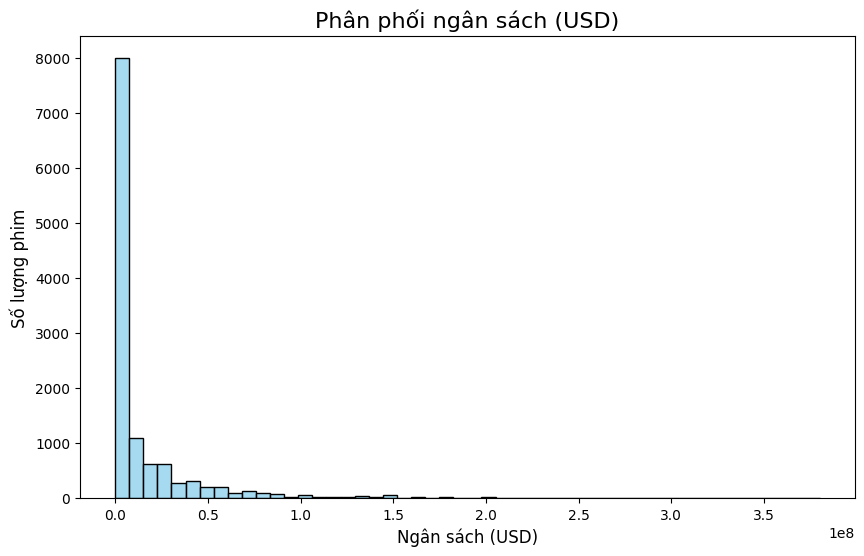

In [13]:
# Thiết lập kích thước biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ histogram cho ngân sách
sns.histplot(data = data_cleaned, x='budget', bins=50, kde=False, color='skyblue')

# Thêm tiêu đề và nhãn
plt.title('Phân phối ngân sách (USD)', fontsize=16)
plt.xlabel('Ngân sách (USD)', fontsize=12)
plt.ylabel('Số lượng phim', fontsize=12)

# Hiển thị biểu đồ
plt.show()


***Nhận xét***
- Phân phối tổng quan:
    + Nếu biểu đồ cho thấy phần lớn các giá trị tập trung ở các mức ngân sách thấp (gần trục y), điều này cho thấy đa số các bộ phim có ngân sách thấp hoặc trung bình.
    + Một số ít bộ phim có ngân sách cao sẽ tạo ra các cột ở phía xa bên phải, thể hiện sự chênh lệch lớn.
- Sự bất đối xứng (Skewness):
    + Nếu biểu đồ nghiêng về bên trái (skewed right), ngân sách của hầu hết các bộ phim nhỏ hơn so với một số ít phim có ngân sách khổng lồ.
    + Ngược lại, nếu đối xứng, ngân sách được phân bổ đồng đều hơn.
- Ngoại lệ (Outliers):
    + Các cột rời rạc ở phần cuối biểu đồ (ngân sách rất cao) có thể đại diện cho các bộ phim bom tấn với đầu tư khổng lồ.
- Khoảng ngân sách phổ biến:
    + Dựa vào biểu đồ, bạn có thể xác định khoảng ngân sách phổ biến nhất (ví dụ: từ 1 triệu đến 10 triệu USD).
    + Điều này có thể cho thấy xu hướng sản xuất phim trong ngành công nghiệp điện ảnh.
- Ý nghĩa:
    + Biểu đồ này giúp nhận diện cách phân bổ nguồn lực trong ngành điện ảnh.
    + Để hiểu thêm, bạn có thể phân tích ngân sách theo thể loại phim, năm sản xuất hoặc các yếu tố khác để tìm hiểu điều gì ảnh hưởng đến quyết định đầu tư.
Kết luận:
    Biểu đồ phân phối ngân sách không chỉ cung cấp cái nhìn tổng quan về ngân sách mà còn giúp xác định xu hướng đầu tư trong lĩnh vực điện ảnh, từ đó hỗ trợ đưa ra các chiến lược đầu tư hợp lý hơn.

2. Biểu đồ phân phối doanh thu (histogram).

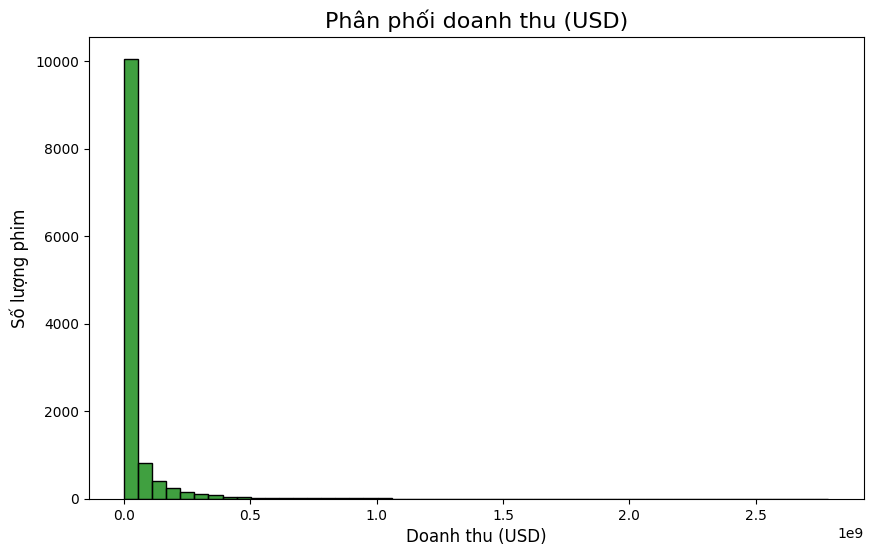

In [14]:
# Thiết lập kích thước biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ histogram cho doanh thu
sns.histplot(data=data_cleaned, x='revenue', bins=50, kde=False, color='green')

# Thêm tiêu đề và nhãn
plt.title('Phân phối doanh thu (USD)', fontsize=16)
plt.xlabel('Doanh thu (USD)', fontsize=12)
plt.ylabel('Số lượng phim', fontsize=12)

# Hiển thị biểu đồ
plt.show()


***Nhận xét***
- Phân phối tổng quan:
    + Nếu biểu đồ cho thấy phần lớn giá trị tập trung ở mức doanh thu thấp, điều này chỉ ra rằng đa số các bộ phim đạt doanh thu ở mức thấp hoặc trung bình.
    + Một số bộ phim có doanh thu rất cao tạo nên các cột ở phía xa bên phải, thể hiện sự chênh lệch lớn trong ngành công nghiệp điện ảnh.
- Sự bất đối xứng (Skewness):
    + Biểu đồ có thể nghiêng về bên trái (skewed right), với phần lớn doanh thu tập trung ở mức thấp và một số ít phim có doanh thu vượt trội.
    + Điều này cho thấy sự bất đối xứng trong việc phân phối doanh thu: một vài phim bom tấn thường tạo ra phần lớn lợi nhuận.
- Ngoại lệ (Outliers):
    +Các cột hoặc điểm rời rạc ở phần cuối biểu đồ (doanh thu rất cao) có thể đại diện cho các phim bom tấn nổi bật, như các phim thuộc chuỗi Marvel, Disney, hoặc các thương hiệu lớn khác.
- Khoảng doanh thu phổ biến:
    + Phân tích biểu đồ có thể giúp xác định khoảng doanh thu phổ biến nhất, ví dụ: từ 1 triệu đến 10 triệu USD, nơi hầu hết các bộ phim đạt được.
- Ý nghĩa:
    + Biểu đồ cho thấy sự phân bổ doanh thu không đồng đều, trong đó chỉ một số ít phim đạt được thành công lớn.
    + Điều này phản ánh tính chất rủi ro trong ngành điện ảnh, nơi một số phim mang lại doanh thu khổng lồ, trong khi phần lớn các phim chỉ đạt doanh thu trung bình hoặc thấp.
- Kết luận:
    + Biểu đồ phân phối doanh thu giúp hiểu rõ hơn về hiệu suất doanh thu của các bộ phim và nhấn mạnh vai trò của các phim bom tấn trong việc tạo ra phần lớn doanh thu của ngành.
    + Để có cái nhìn sâu hơn, có thể kết hợp phân tích doanh thu theo ngân sách, thể loại phim hoặc đạo diễn để xác định các yếu tố ảnh hưởng đến thành công thương mại.

3. Biểu đồ phân phối đánh giá trung bình.

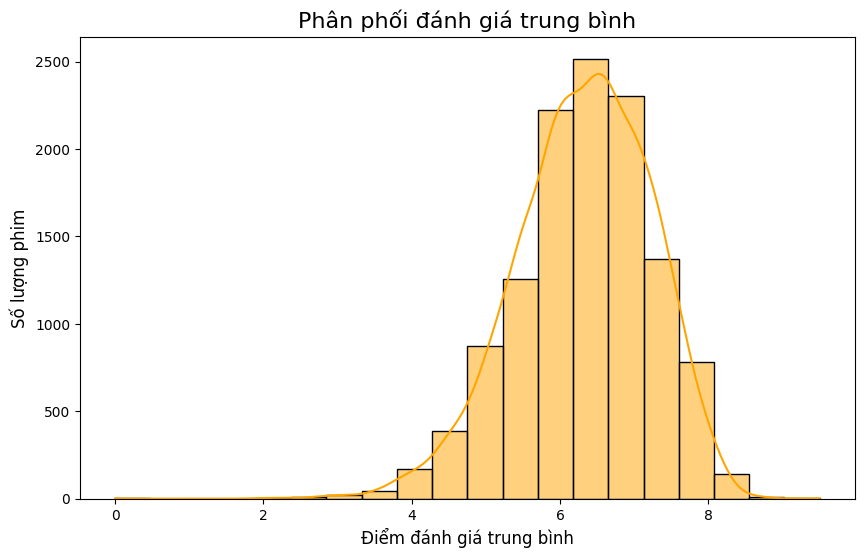

In [15]:
#  Thiết lập kích thước biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ histogram cho đánh giá trung bình
sns.histplot(data=data_cleaned, x='vote_average', bins=20, kde=True, color='orange')

# Thêm tiêu đề và nhãn
plt.title('Phân phối đánh giá trung bình', fontsize=16)
plt.xlabel('Điểm đánh giá trung bình', fontsize=12)
plt.ylabel('Số lượng phim', fontsize=12)

# Hiển thị biểu đồ
plt.show()


***Nhận xét***
- Phân phối tổng quan:
    + Nếu biểu đồ cho thấy một sự tập trung lớn ở điểm thấp (gần 0 hoặc 1) và dần giảm dần về phía điểm cao (gần 10), điều này có thể cho thấy đa số các bộ phim nhận được đánh giá trung bình hoặc thấp.
    + Nếu phần lớn các điểm tập trung ở khoảng giữa (5-7), điều này chỉ ra rằng các bộ phim nhận được đánh giá trung bình.
- Sự bất đối xứng (Skewness):
    + Biểu đồ có thể nghiêng về phía bên trái (skewed left), với hầu hết các bộ phim có điểm đánh giá thấp.
    Hoặc nếu biểu đồ nghiêng về bên phải, điều đó chỉ ra rằng các bộ phim có xu hướng nhận đánh giá cao hơn, nhưng ít phim đạt được điểm tuyệt đối.
- Ngoại lệ (Outliers):
    + Các điểm ở phần cuối của biểu đồ (điểm đánh giá rất cao hoặc rất thấp) có thể đại diện cho các bộ phim đặc biệt, có thể là một thất bại lớn hoặc một bộ phim được yêu thích và đánh giá rất cao.
- Ví dụ, các bộ phim giành giải thưởng hoặc nổi bật về nghệ thuật thường có điểm đánh giá cao hơn.
- Khoảng đánh giá phổ biến:
    + Phân tích biểu đồ có thể giúp xác định khoảng đánh giá phổ biến nhất, chẳng hạn như 6-7/10, nơi đa số các bộ phim được đánh giá.
    + Nếu phần lớn điểm đánh giá nằm gần mức trung bình, điều này chỉ ra rằng không có sự chênh lệch quá lớn trong sự yêu thích của các bộ phim.
- Ý nghĩa:
    + Biểu đồ này cung cấp cái nhìn về chất lượng tổng thể của các bộ phim trong dữ liệu, cho thấy phần lớn các bộ phim nhận được những đánh giá ở mức trung bình.
    + Nếu có sự phân bố tập trung vào các điểm đánh giá thấp, có thể cần xem xét lại các yếu tố ảnh hưởng đến sự đánh giá, chẳng hạn như thể loại phim, diễn viên, đạo diễn, hay chiến lược marketing.

4. Biểu đồ phân tán ngân sách và doanh thu.

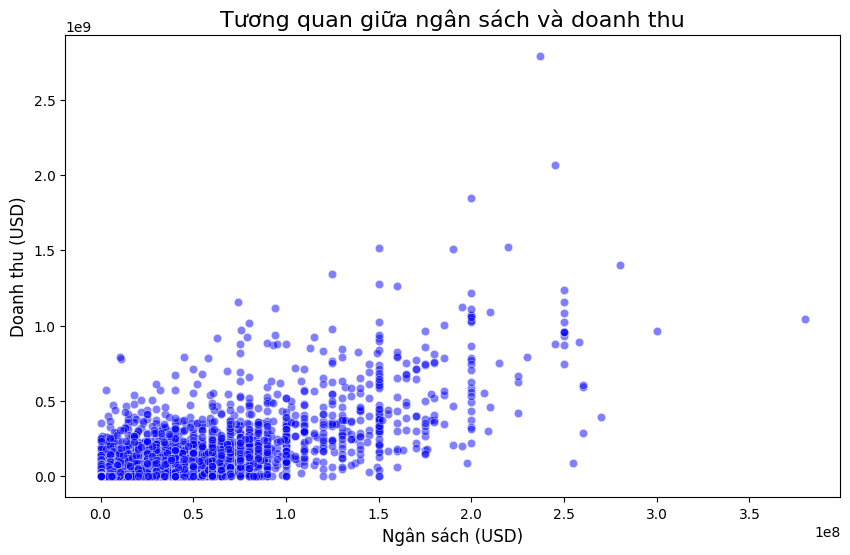

In [16]:
# Thiết lập kích thước biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ phân tán giữa ngân sách và doanh thu
sns.scatterplot(data=data_cleaned, x='budget', y='revenue', alpha=0.5, color='blue')

# Thêm tiêu đề và nhãn
plt.title('Tương quan giữa ngân sách và doanh thu', fontsize=16)
plt.xlabel('Ngân sách (USD)', fontsize=12)
plt.ylabel('Doanh thu (USD)', fontsize=12)

# Hiển thị biểu đồ
plt.show()


***Nhận xét***
- Xu hướng tổng quan:
    + Nếu biểu đồ cho thấy một xu hướng tăng (điểm dữ liệu tạo thành đường chéo hướng lên), điều này chỉ ra rằng các bộ phim có ngân sách cao thường đạt được doanh thu lớn hơn. Tuy nhiên, mức độ tương quan có thể không phải là hoàn toàn tuyến tính.
- Sự phân tán dữ liệu:
    + Nếu có nhiều điểm tập trung gần gốc tọa độ, điều đó cho thấy có rất nhiều bộ phim có ngân sách và doanh thu thấp.
    Một số điểm nằm xa gốc tọa độ, đặc biệt là ở phía trên bên phải, có thể đại diện cho các bộ phim bom tấn với ngân sách lớn và doanh thu khổng lồ.
- Ngoại lệ (Outliers):
    + Các điểm nằm lệch khỏi xu hướng chung có thể là ngoại lệ. Ví dụ:
    + Bộ phim có ngân sách rất lớn nhưng doanh thu thấp có thể là một thất bại.
    + Bộ phim có ngân sách nhỏ nhưng doanh thu cao là một thành công vượt trội.
- Mật độ dữ liệu:
    + Nếu biểu đồ cho thấy rất nhiều điểm chồng chéo ở một khu vực (thường là ở ngân sách và doanh thu thấp), điều này cho thấy phần lớn các bộ phim nằm trong khoảng này.
- Kết luận:
    + Biểu đồ giúp xác định mối quan hệ giữa ngân sách và doanh thu, cung cấp thông tin hữu ích để đánh giá hiệu quả đầu tư.
    + Phân tích sâu hơn có thể bao gồm việc tính toán hệ số tương quan hoặc kiểm tra các yếu tố khác như thể loại phim, đạo diễn, hoặc chiến dịch marketing để hiểu rõ hơn về những gì ảnh hưởng đến doanh thu.

5. Biểu đồ phân tán số lượt bình chọn và đánh giá.

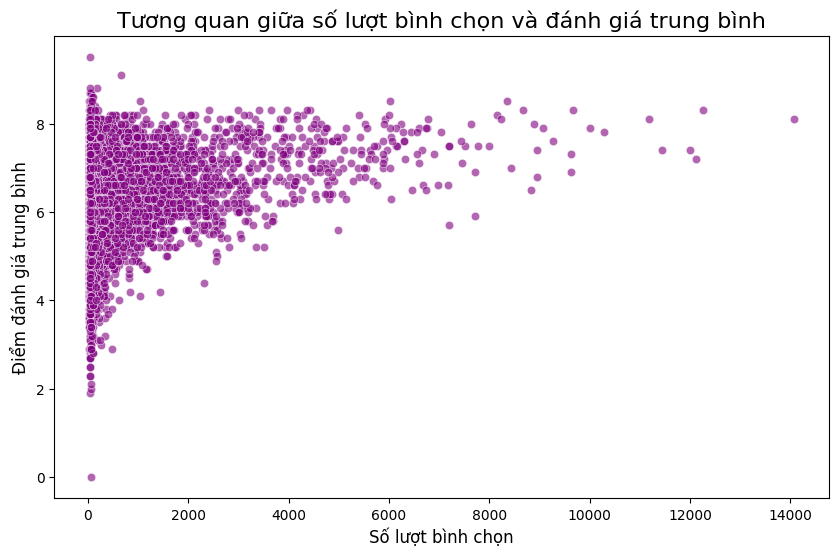

In [17]:
# Thiết lập kích thước biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ phân tán giữa số lượt bình chọn và đánh giá trung bình
sns.scatterplot(data=data_cleaned, x='vote_count', y='vote_average', alpha=0.6, color='purple')

# Thêm tiêu đề và nhãn
plt.title('Tương quan giữa số lượt bình chọn và đánh giá trung bình', fontsize=16)
plt.xlabel('Số lượt bình chọn', fontsize=12)
plt.ylabel('Điểm đánh giá trung bình', fontsize=12)

# Hiển thị biểu đồ
plt.show()


***Nhận xét***
- Tương quan tổng quan:
    + Nếu biểu đồ cho thấy một tập hợp dày đặc các điểm dữ liệu ở phía dưới trục hoành và phân bố thưa dần khi tiến về bên phải, điều này cho thấy phần lớn các bộ phim có ít lượt bình chọn.
    + Các phim có số lượt bình chọn cao thường là những phim nổi tiếng hoặc bom tấn, nhưng không phải lúc nào cũng có điểm đánh giá cao.
- Phân bố điểm đánh giá:
    + Điểm đánh giá trung bình (trục tung) thường tập trung trong khoảng 5-8, cho thấy đa số phim nhận được đánh giá trung bình hoặc khá cao.
    + Một số phim có điểm thấp hơn 5 hoặc cao hơn 8 là các phim gây tranh cãi hoặc được yêu thích đặc biệt.
- Ngoại lệ (Outliers):
    + Các điểm nằm ở phía xa bên phải với số lượt bình chọn rất cao có thể đại diện cho các phim bom tấn hoặc rất nổi tiếng.
    + Những phim có nhiều lượt bình chọn nhưng điểm đánh giá thấp (dưới 5) có thể là phim thất bại về chất lượng nhưng vẫn thu hút khán giả nhờ quảng bá.
- Ý nghĩa:
    + Phim có ít lượt bình chọn thường là phim không phổ biến, và điểm đánh giá của chúng dễ bị lệch bởi một nhóm nhỏ khán giả.
    + Các phim có lượt bình chọn cao có xu hướng phản ánh chính xác hơn về chất lượng thông qua điểm đánh giá, vì số lượng người tham gia lớn giúp giảm thiên lệch.
    
***Kết luận:***
- Biểu đồ cho thấy số lượt bình chọn không luôn đi kèm với điểm đánh giá cao, nhưng có một sự tương quan nhất định giữa độ phổ biến và chất lượng phim.
- Để hiểu sâu hơn, có thể phân tích thêm các yếu tố khác như thể loại phim, năm phát hành hoặc ngân sách để kiểm tra ảnh hưởng của chúng đến số lượt bình chọn và đánh giá.

6. Top 10 thể loại phổ biến (bar chart).


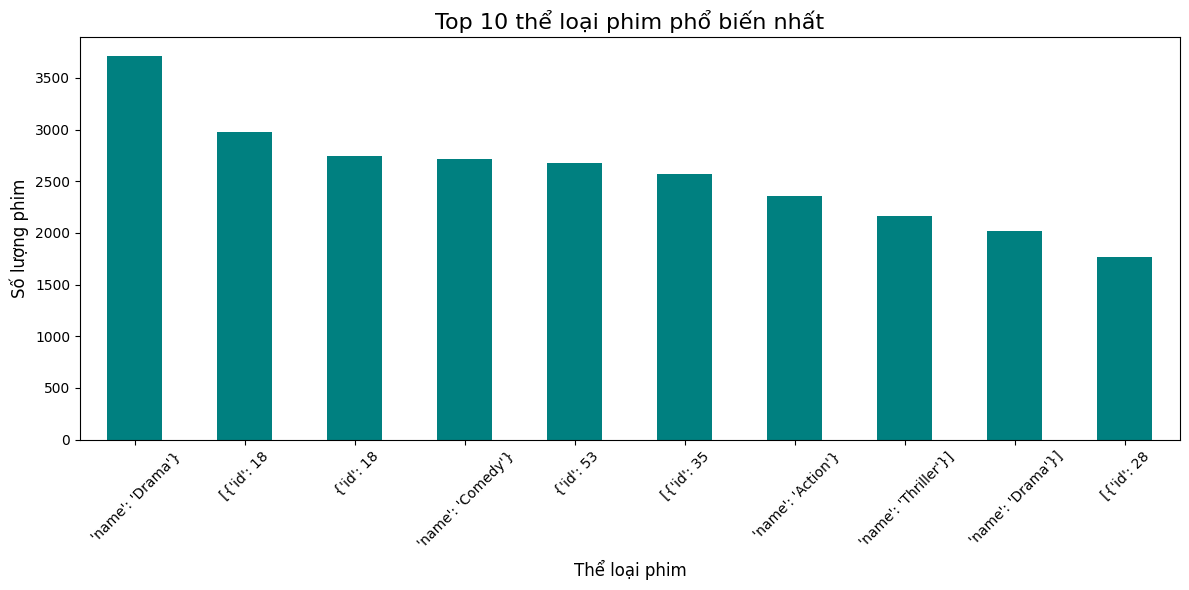

In [18]:
# Tách các thể loại phim và đếm tần suất
genres_exploded = data_cleaned['genres'].str.split(',').explode()
top_10_genres = genres_exploded.value_counts().head(10)

# Thiết lập kích thước biểu đồ
plt.figure(figsize=(12, 6))

# Vẽ biểu đồ thanh
top_10_genres.plot(kind='bar', color='teal')

# Thêm tiêu đề và nhãn
plt.title('Top 10 thể loại phim phổ biến nhất', fontsize=16)
plt.xlabel('Thể loại phim', fontsize=12)
plt.ylabel('Số lượng phim', fontsize=12)

# Xoay nhãn trên trục x để dễ đọc
plt.xticks(rotation=45)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


***Nhận xét***
- Phân bố thể loại:
    + Biểu đồ cho thấy thể loại phổ biến nhất trong dữ liệu, ví dụ như: Drama, Comedy, Action, và Adventure. Đây thường là những thể loại thu hút lượng lớn khán giả và được sản xuất nhiều.
    + Các thể loại ở cuối Top 10 như Thriller hoặc Romance tuy ít phổ biến hơn nhưng vẫn có số lượng đáng kể.
- Khoảng cách giữa các thể loại:
    + Nếu có sự chênh lệch lớn giữa các cột, điều này cho thấy một vài thể loại thống trị ngành công nghiệp điện ảnh.
    + Nếu khoảng cách giữa các thể loại gần nhau, điều này phản ánh sự đa dạng trong việc sản xuất phim, không có thể loại nào quá vượt trội.
- Xu hướng sản xuất:
    + Các thể loại phổ biến như Drama và Comedy thường được ưu tiên bởi tính phổ quát, phù hợp với nhiều đối tượng khán giả.
    + Các thể loại như Action và Adventure phổ biến nhờ vào hiệu ứng kỹ xảo, sức hấp dẫn với khán giả trẻ.
- Ý nghĩa:
    + Biểu đồ giúp nhà sản xuất hiểu rõ hơn về xu hướng thị trường và thị hiếu khán giả.
    + Các thể loại phổ biến thường có cơ hội thu hút nhiều người xem hơn, nhưng cũng đối mặt với sự cạnh tranh lớn hơn.
    
***Kết luận***
- Biểu đồ cung cấp cái nhìn tổng quan về sự phổ biến của các thể loại phim, từ đó hỗ trợ việc đưa ra các quyết định chiến lược, chẳng hạn như đầu tư vào các thể loại đang thịnh hành hoặc khám phá những thể loại ít phổ biến hơn để tạo sự khác biệt.

7. Top 10 hãng sản xuất phổ biến (bar chart).

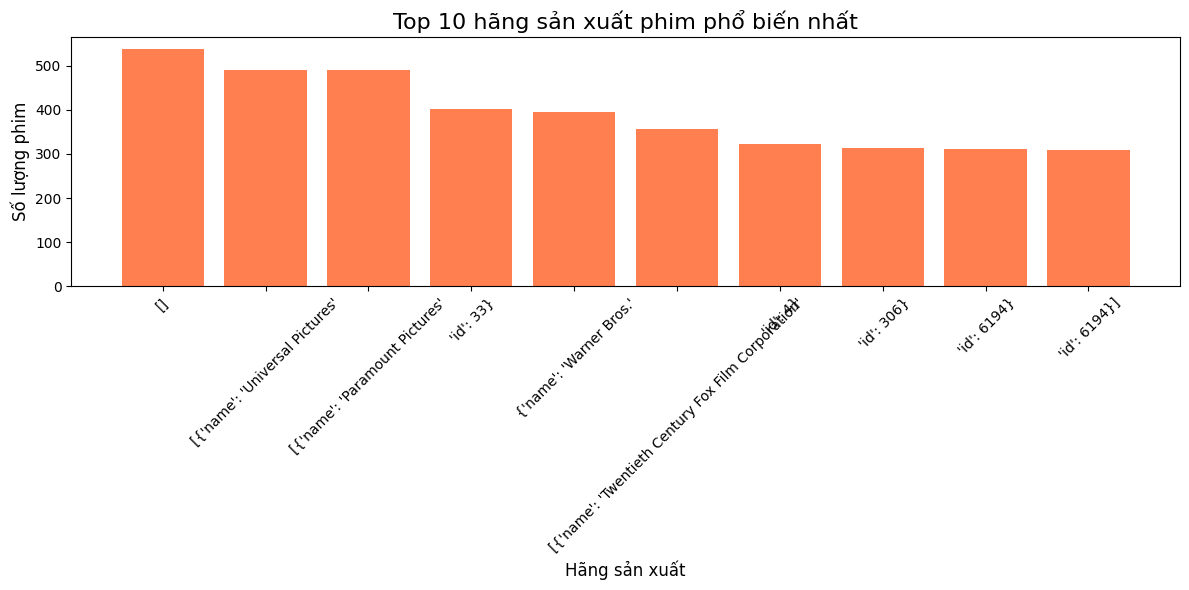

In [19]:
# Tách các hãng sản xuất và đếm tần suất
production_companies_exploded = data_cleaned['production_companies'].str.split(',').explode()
top_10_companies = production_companies_exploded.value_counts().head(10)

# Thiết lập kích thước biểu đồ
plt.figure(figsize=(12, 6))

# Vẽ biểu đồ thanh
plt.bar(top_10_companies.index, top_10_companies.values, color='coral')

# Thêm tiêu đề và nhãn
plt.title('Top 10 hãng sản xuất phim phổ biến nhất', fontsize=16)
plt.xlabel('Hãng sản xuất', fontsize=12)
plt.ylabel('Số lượng phim', fontsize=12)

# Đặt nhãn cụ thể trên trục X
plt.xticks(ticks=range(len(top_10_companies.index)), labels=top_10_companies.index, rotation=45, fontsize=10)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


***Nhận xét***
- Hãng sản xuất dẫn đầu:
    + Hãng sản xuất đứng đầu (ví dụ: Warner Bros., Universal Pictures, hoặc Paramount Pictures) có số lượng phim vượt trội, phản ánh quy mô và năng lực sản xuất lớn của các hãng này.
    + Những hãng này thường gắn liền với các thương hiệu phim nổi tiếng hoặc bom tấn, đóng vai trò quan trọng trong ngành công nghiệp điện ảnh.
- Chênh lệch số lượng phim:
    + Nếu cột đầu tiên (hãng dẫn đầu) cao hơn hẳn các cột còn lại, điều này cho thấy sự thống trị của một số ít hãng sản xuất lớn.
    + Nếu chiều cao các cột gần bằng nhau, điều đó phản ánh sự cạnh tranh đồng đều giữa các hãng.
- Sự xuất hiện của các hãng nhỏ hơn:
    + Các hãng ở cuối Top 10 có thể là những đơn vị sản xuất vừa và nhỏ nhưng vẫn có ảnh hưởng lớn hoặc tham gia hợp tác sản xuất với các hãng lớn.
- Xu hướng sản xuất phim:
    + Các hãng đứng đầu thường có xu hướng sản xuất đa dạng thể loại phim và hướng đến thị trường quốc tế.
    Sự phổ biến của một hãng có thể liên quan đến các thương hiệu phim nổi bật, ví dụ: Disney với phim hoạt hình hoặc Warner Bros. với phim siêu anh hùng.
- Ý nghĩa:
    + Biểu đồ cung cấp cái nhìn tổng quan về sự đóng góp của các hãng sản xuất vào ngành công nghiệp điện ảnh.
    Những hãng sản xuất phổ biến thường có sức ảnh hưởng lớn và khả năng phát triển các dự án phim quy mô lớn, thu hút sự chú ý của khán giả toàn cầu.

***Kết luận:***
- Biểu đồ nhấn mạnh vai trò quan trọng của các hãng sản xuất lớn trong việc định hình xu hướng và nội dung phim.
Các hãng sản xuất nhỏ trong Top 10 cũng đáng chú ý vì sự hiện diện của họ cho thấy khả năng cạnh tranh hoặc sự hợp tác với các hãng lớn.

8. Biểu đồ tỷ lệ phim theo trạng thái (pie chart).


9. Biểu đồ xu hướng số lượng phim qua các năm (line chart).

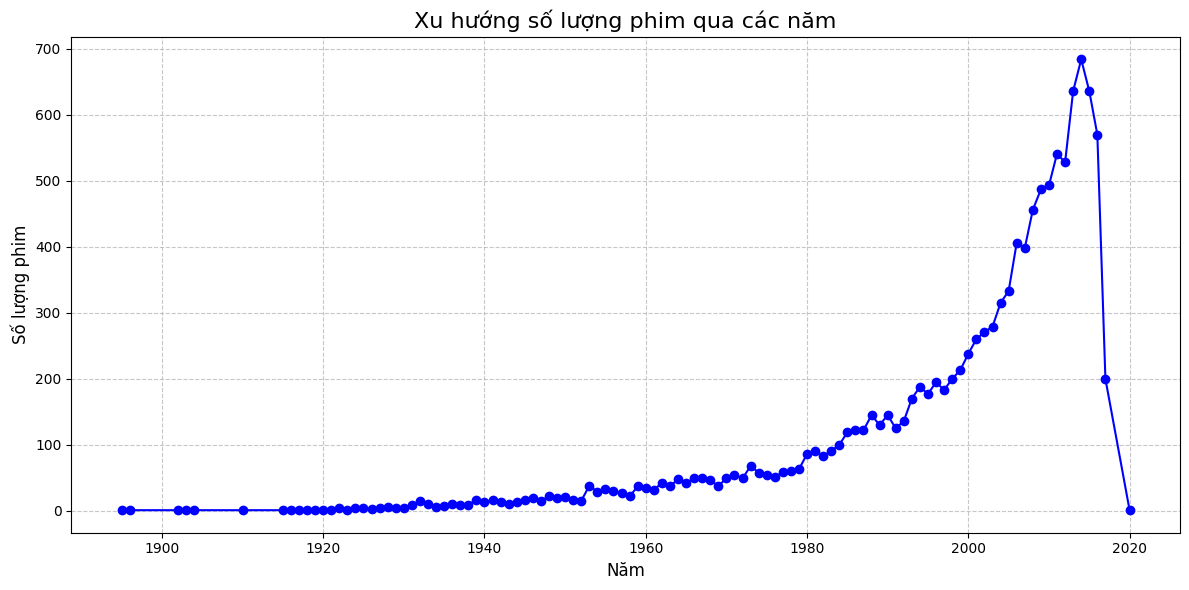

In [21]:
# Trích xuất dữ liệu năm từ cột release_date
data_cleaned['release_year'] = pd.to_datetime(data_cleaned['release_date']).dt.year

# Đếm số lượng phim theo từng năm
movies_per_year = data_cleaned['release_year'].value_counts().sort_index()

# Thiết lập kích thước biểu đồ
plt.figure(figsize=(12, 6))

# Vẽ biểu đồ đường
plt.plot(movies_per_year.index, movies_per_year.values, marker='o', linestyle='-', color='b')

# Thêm tiêu đề và nhãn
plt.title('Xu hướng số lượng phim qua các năm', fontsize=16)
plt.xlabel('Năm', fontsize=12)
plt.ylabel('Số lượng phim', fontsize=12)

# Hiển thị lưới
plt.grid(visible=True, linestyle='--', alpha=0.7)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()
